# 基于Transformer的数学应用题求解器

## 1. 数据集准备

我们使用 [Math23K](https://paperswithcode.com/dataset/math23k) 数据集，其中包含数学应用题以及对应的方程。

In [1]:
import json
import math

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import Dataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PAD_IDX = 1

# Set seed.
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [2]:
# 读取Math23K数据集
def read_math23k_data(path):
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    problems = [item["text"].split() for item in data]  # 将问题文本分割成单词
    equations = [item["target_template"][2:] for item in data]  # 移除方程的 'x=' 前缀
    return problems, equations


train_path, test_path = "data/train.json", "data/test.json"
# 加载数据集
train_problems, train_equations = read_math23k_data("data/train.json")
test_problems, test_equations = read_math23k_data("data/test.json")

print(f"训练集大小: {len(train_problems)}")
print(f"测试集大小: {len(test_problems)}")

训练集大小: 22162
测试集大小: 1000


让我们看一下数据集中的示例。

In [3]:
for i in range(3):
    print(f"问题 {i+1}: {train_problems[i]}")
    print(f"方程 {i+1}: {train_equations[i]}")
    print("-" * 20)

问题 1: ['甲数', '除以', '乙数', '的', '商是', 'temp_a', '，', '如果', '甲数', '增加', 'temp_b', '，', '则', '甲数', '是', '乙', '的', 'temp_c', '倍', '．', '原来', '甲数', '=', '．']
方程 1: ['temp_b', '/', '(', 'temp_c', '-', 'temp_a', ')', '*', 'temp_a']
--------------------
问题 2: ['客车', '和', '货车', '分别', '从', 'A', '、', 'B', '两站', '同时', '相向', '开出', '，', 'temp_a', '小时', '后', '相遇', '．', '相遇', '后', '，', '两车', '仍', '按原', '速度', '前进', '，', '当', '它们', '相距', 'temp_b', '千米', '时', '，', '货车', '行', '了', '全程', '的', 'temp_c', '%', '，', '客车', '已行', '的', '路程', '与', '未行', '的', '路程', '比是', 'temp_d', '：', 'temp_e', '．', '求', 'A', '、', 'B', '两站', '间', '的', '路程', '．']
方程 2: ['temp_b', '/', '(', 'temp_c', '+', '(', '(', 'temp_d', ')', '/', '(', 'temp_d', '+', 'temp_e', ')', ')', '-', '1', ')']
--------------------
问题 3: ['图书', '角有', '书', 'temp_a', '本', '，', '第一天', '借出', '了', 'temp_b', '，', '第二天', '又', '还', '回', 'temp_c', '本', '，', '现在', '图书', '角有', '多少', '本书', '？']
方程 3: ['temp_a', '*', '(', '1', '-', 'temp_b', ')', '+', 'temp_c']
-------

## 2. 数据预处理

为了使用Transformer模型，我们需要对文本数据进行编码。我们将使用词汇表和Tokenization方法来处理这些文本。

### 2.1 创建词汇表

我们将构建一个 Vocab 类，将每个 token 映射到一个唯一的整数 ID，并定义反向的映射。

In [4]:
from collections import Counter


class Vocab:
    def __init__(self, sentence_list, min_count=1):
        self.token2idx = {"<unk>": 0, "<pad>": 1, "<bos>": 2, "<eos>": 3}
        self.build_vocab(sentence_list, min_count)

    def build_vocab(self, sentence_list, min_count):
        # 统计词频
        token_counts = Counter([token for sentence in sentence_list for token in sentence])
        # 对词汇按频率排序并为频率大于等于min_count的词汇分配索引
        sorted_tokens = [token for token, count in token_counts.items() if count >= min_count]
        sorted_tokens.sort(key=lambda token: token_counts[token], reverse=True)
        for token in sorted_tokens:
            self.token2idx[token] = len(self.token2idx)
        # 创建反向索引
        self.idx2token = {idx: token for token, idx in self.token2idx.items()}

    def __len__(self):
        return len(self.idx2token)

    def token_to_index(self, token):
        if isinstance(token, str):
            return self.token2idx.get(token, self.token2idx["<unk>"])
        else:
            raise TypeError("Token should be a string")

    def index_to_token(self, index):
        if isinstance(index, int):
            return self.idx2token.get(index, "<unk>")
        else:
            raise TypeError("Index should be an integer")

    def to_tokens(self, indices):
        return [self.index_to_token(index) for index in indices]

    def to_indices(self, tokens):
        return [self.token_to_index(token) for token in tokens]

    def __repr__(self):
        return f"Vocab(size={len(self)})"

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_index(tokens)
        return [self.token_to_index(token) for token in tokens]


src_vocab = Vocab(train_problems + test_problems)
tgt_vocab = Vocab(train_equations + test_equations)
print(f"Source Vocab Size: {len(src_vocab)}")
print(f"Target Vocab Size: {len(tgt_vocab)}")

Source Vocab Size: 15452
Target Vocab Size: 30


下面我们将使用一些示例数据来演示 Vocab 的用法：

In [5]:
example_tokens = [["我", "爱", "学习"], ["学习", "使", "我", "快乐"], ["深度", "学习", "很", "有趣"]]
example_vocab = Vocab(example_tokens)
print(f"vocab 大小: {len(example_vocab)}")
print("-" * 20)
print("token 到 index的映射:")
for token, idx in example_vocab.token2idx.items():
    print(f"{token}: {idx}")
print("-" * 20)
print(f"example_tokens[0] 转换为index: {example_vocab[example_tokens[0]]}")

vocab 大小: 12
--------------------
token 到 index的映射:
<unk>: 0
<pad>: 1
<bos>: 2
<eos>: 3
学习: 4
我: 5
爱: 6
使: 7
快乐: 8
深度: 9
很: 10
有趣: 11
--------------------
example_tokens[0] 转换为index: [5, 6, 4]


### 2.2 生成数据集

我们要对数据先进行以下预处理：

1. **添加特殊标记（Adding Special Tokens）**：在输入序列的开头和末尾添加特殊标记，如开始标记（`<bos>`）和结束标记（`<eos>`），以及填充标记（`<pad>`）等。这些标记有助于模型更好地理解输入序列的边界和结构。

2. **数据向量化（Vectorization）**：将文本数据转换为模型可以处理的数值张量形式。

3. **填充和截断（Padding and Truncation）**：Transformer 模型对于输入序列的长度通常是固定的，因此需要对输入序列进行填充（padding）或截断（truncation），使得所有序列具有相同的长度。

In [6]:
def preprocess_sentence(sentence, vocab, max_len):
    # 1. 添加特殊符号
    sentence = ["<bos>"] + sentence + ["<eos>"]
    # 2. 将词汇转换为索引
    indices = vocab[sentence]
    # 3. 将索引转换为张量
    indices = torch.tensor(indices)
    # 4. 填充PAD
    if len(indices) > max_len:
        indices = indices[:max_len]
    else:
        pad_size = max_len - len(indices)
        indices = F.pad(indices, (0, pad_size), value=vocab["<pad>"])
    return indices


class Math23kDataset(Dataset):
    def __init__(self, problems, equations, src_vocab, tgt_vocab):
        src_max_len, tgt_max_len = 120, 50
        src_data = [preprocess_sentence(sentence, src_vocab, src_max_len) for sentence in problems]
        tgt_data = [preprocess_sentence(sentence, tgt_vocab, tgt_max_len) for sentence in equations]
        self.src_data = torch.stack(src_data).to(DEVICE)
        self.tgt_data = torch.stack(tgt_data).to(DEVICE)

    def __len__(self):
        return len(self.src_data)

    def __getitem__(self, idx):
        return self.src_data[idx], self.tgt_data[idx]


train_dataset = Math23kDataset(train_problems, train_equations, src_vocab, tgt_vocab)
test_dataset = Math23kDataset(test_problems, test_equations, src_vocab, tgt_vocab)

In [7]:
src_example, tgt_example = train_dataset[0]
print("src example:", src_example)
print("src text:", " ".join(src_vocab.to_tokens(src_example.tolist())))
print("-" * 20)
print("tgt example:", tgt_example)
print("tgt text:", " ".join(tgt_vocab.to_tokens(tgt_example.tolist())))

src example: tensor([  2, 207, 354, 212,   5, 469,   6,   4,  55, 207, 206,   7,   4, 225,
        207,  15,  78,   5,  11,  54,  10,  71, 207,  19,  10,   3,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1], device='cuda:0')
src text: <bos> 甲数 除以 乙数 的 商是 temp_a ， 如果 甲数 增加 temp_b ， 则 甲数 是 乙 的 temp_c 倍 ． 原来 甲数 = ． <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad

## 3. 构建 Transformer 模型


### 3.1 位置编码

In [8]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(-torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer("pos_embedding", pos_embedding)

    def forward(self, token_embedding: Tensor):
        """
        Shape:
            token_embedding: [batch_size, seq_len, emb_size]
            output: [batch_size, seq_len, emb_size]
        """
        return self.dropout(token_embedding + self.pos_embedding[: token_embedding.size(1), :])

### 3.2 Seq2Seq 模型

In [9]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)


class Seq2SeqTransformer(nn.Module):
    def __init__(
        self,
        num_encoder_layers: int,
        num_decoder_layers: int,
        emb_size,
        nhead,
        src_vocab_size,
        tgt_vocab_size,
        dim_feedforward: int = 512,
        dropout: float = 0.1,
    ):
        super(Seq2SeqTransformer, self).__init__()

        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.transformer = nn.Transformer(
            d_model=emb_size,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.generator = nn.Linear(emb_size, tgt_vocab_size)

    def forward(
        self,
        src: Tensor,
        trg: Tensor,
        src_mask: Tensor,
        tgt_mask: Tensor,
        src_padding_mask: Tensor,
        tgt_padding_mask: Tensor,
        memory_padding_mask: Tensor,
    ):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(
            src_emb, tgt_emb, src_mask, tgt_mask, None, src_padding_mask, tgt_padding_mask, memory_padding_mask
        )
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor, src_key_padding_mask=None):
        return self.transformer.encoder(self.positional_encoding(self.src_tok_emb(src)), src_mask, src_key_padding_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(self.tgt_tok_emb(tgt)), memory, tgt_mask)

## 4. 训练模型

### 4.1 定义训练函数和评估函数

In [10]:
def create_mask(src, tgt):
    src_seq_len = src.shape[1]
    tgt_seq_len = tgt.shape[1]

    src_mask = torch.zeros((src_seq_len, src_seq_len), dtype=torch.bool, device=DEVICE)
    tgt_mask = torch.ones((tgt_seq_len, tgt_seq_len), dtype=torch.bool, device=DEVICE).triu_(diagonal=1)

    src_padding_mask = src == PAD_IDX
    tgt_padding_mask = tgt == PAD_IDX
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask


batch_src, batch_tgt = train_dataset[0:2]
src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(batch_src, batch_tgt)
print(src_mask)
print(tgt_mask)
print(src_padding_mask)

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]], device='cuda:0')
tensor([[False,  True,  True,  ...,  True,  True,  True],
        [False, False,  True,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        ...,
        [False, False, False,  ..., False,  True,  True],
        [False, False, False,  ..., False, False,  True],
        [False, False, False,  ..., False, False, False]], device='cuda:0')
tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False,  True,  True,  True,  True,
     

In [11]:
# 训练和评估函数
def train_epoch(model, train_loader, optimizer, loss_fn):
    model.train()
    losses = 0
    for src, tgt in train_loader:
        src, tgt = src.to(DEVICE), tgt.to(DEVICE)
        tgt_input = tgt[:, :-1]
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)
        optimizer.zero_grad()

        tgt_out = tgt[:, 1:]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

        optimizer.step()
        losses += loss.item()

    return losses / len(train_loader)


def evaluate(model, val_loader, loss_fn):
    model.eval()
    losses = 0
    for src, tgt in val_loader:
        src, tgt = src.to(DEVICE), tgt.to(DEVICE)
        tgt_input = tgt[:, :-1]
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[:, 1:]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(val_loader)

### 4.2 设置超参数和初始化模型

我们将定义模型、优化器和损失函数，并设置训练所需的参数。

In [12]:
# 模型超参数
SRC_VOCAB_SIZE = len(src_vocab)
TGT_VOCAB_SIZE = len(tgt_vocab)
EMB_SIZE = 128
NHEAD = 8  # 注意力头数
FFN_HID_DIM = 512  # FeedForward隐藏层维度
NUM_LAYERS = 4  # Transformer层数

BATCH_SIZE = 128
LEARNING_RATE = 0.0008
DROP_OUT = 0.1

model = Seq2SeqTransformer(
    NUM_LAYERS, NUM_LAYERS, EMB_SIZE, NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM, DROP_OUT
)

total_params = sum(p.numel() for p in model.parameters())
print("Total params:", total_params / 1e6, "M")

model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab["<pad>"])
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

Total params: 3.83747 M


### 4.3 开始训练

In [13]:
from timeit import default_timer as timer
from torch.utils.data import DataLoader

NUM_EPOCHS = 30

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

train_loss_list, valid_loss_list = [], []

for epoch in range(NUM_EPOCHS):
    start_time = timer()
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss = evaluate(model, val_loader, criterion)
    end_time = timer()
    train_loss_list.append(train_loss)
    valid_loss_list.append(val_loss)
    print(
        (
            f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "
            f"Epoch time = {(end_time - start_time):.3f}s"
        )
    )

# 保存模型
torch.save(model.state_dict(), "model.pth")

Epoch: 0, Train loss: 1.194, Val loss: 0.907, Epoch time = 10.355s
Epoch: 1, Train loss: 0.891, Val loss: 0.812, Epoch time = 10.252s
Epoch: 2, Train loss: 0.811, Val loss: 0.734, Epoch time = 10.252s
Epoch: 3, Train loss: 0.759, Val loss: 0.726, Epoch time = 10.252s
Epoch: 4, Train loss: 0.720, Val loss: 0.686, Epoch time = 10.251s
Epoch: 5, Train loss: 0.680, Val loss: 0.647, Epoch time = 10.251s
Epoch: 6, Train loss: 0.650, Val loss: 0.638, Epoch time = 10.251s
Epoch: 7, Train loss: 0.624, Val loss: 0.630, Epoch time = 10.251s
Epoch: 8, Train loss: 0.603, Val loss: 0.601, Epoch time = 10.251s
Epoch: 9, Train loss: 0.583, Val loss: 0.576, Epoch time = 10.252s
Epoch: 10, Train loss: 0.564, Val loss: 0.570, Epoch time = 10.252s
Epoch: 11, Train loss: 0.547, Val loss: 0.556, Epoch time = 10.251s
Epoch: 12, Train loss: 0.532, Val loss: 0.556, Epoch time = 10.252s
Epoch: 13, Train loss: 0.517, Val loss: 0.540, Epoch time = 10.251s
Epoch: 14, Train loss: 0.500, Val loss: 0.536, Epoch time 

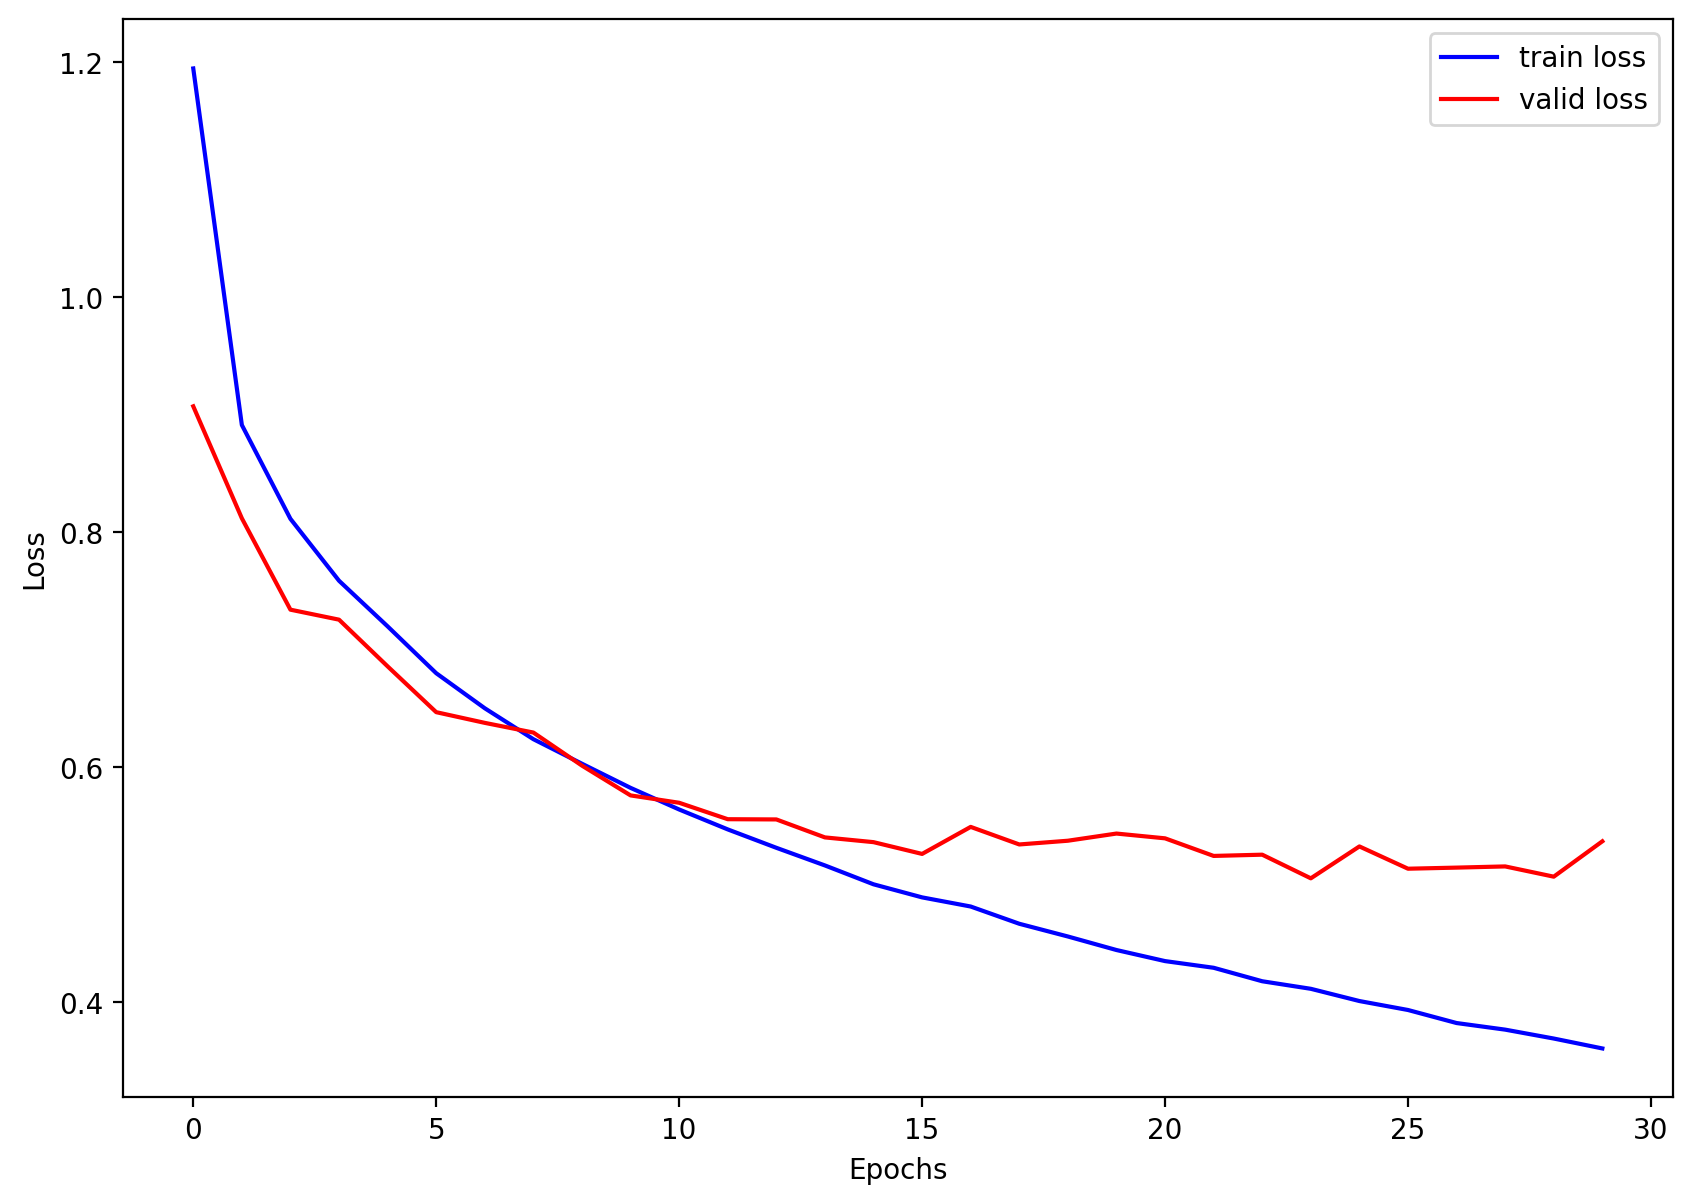

In [14]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
plt.figure(figsize=(10, 7))
plt.plot(train_loss_list, color="blue", linestyle="-", label="train loss")
plt.plot(valid_loss_list, color="red", linestyle="-", label="valid loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## 5. 模型评估

在这一部分，我们将使用测试集上的方程准确率对模型进行评估。

In [15]:
def equation_accuracy(preds, tgts):
    correct = 0
    for tgt, pred in zip(tgts, preds):
        if tgt == pred:
            correct += 1
    return correct / len(tgts)


@torch.no_grad()
def greedy_decode(model, src, max_len, start_symbol):
    src = src.to(DEVICE)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    src_mask, tgt_mask, src_padding_mask, _ = create_mask(src, ys)

    memory = model.encode(src, src_mask, src_padding_mask)

    for i in range(max_len - 1):
        tgt_mask = torch.ones((ys.shape[1], ys.shape[1]), dtype=torch.bool, device=DEVICE).triu_(diagonal=1)

        out = model.decode(ys, memory, tgt_mask)

        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type(torch.long).to(DEVICE)], dim=1)
        if next_word == tgt_vocab["<eos>"]:
            break
    return ys


@torch.no_grad()
def inference(model, problem):
    model.eval()
    src = preprocess_sentence(problem, src_vocab, 120)
    src = src.unsqueeze(0)
    tgt_tokens = greedy_decode(model, src, max_len=50, start_symbol=tgt_vocab["<bos>"]).flatten()
    return "".join(tgt_vocab.to_tokens(tgt_tokens.tolist())).replace("<bos>", "").replace("<eos>", "")

In [16]:
for i in range(5):
    problem, equation = test_problems[i], test_equations[i]
    print(f"问题 {i+1}: {''.join(problem)}")
    print(f"真实方程: {''.join(equation)}")
    print(f"预测方程: {inference(model, problem)}")
    print("-" * 20)

问题 1: 在一正方形花池的四周栽了temp_a棵柳树，每两棵柳树之间的间隔是temp_b米，这个正方形的周长=多少米？
真实方程: temp_a*temp_b
预测方程: temp_b*temp_a
--------------------
问题 2: 张明有temp_a元钱，买书用去temp_b%，买文具的钱是买书的temp_c%．买文具用去多少元？
真实方程: temp_a*temp_b*temp_c
预测方程: temp_a*temp_b*temp_c
--------------------
问题 3: 一个工厂要生产temp_a个零件，前temp_b天生产了temp_c个，剩下的要在temp_d天内完成，平均每天生产多少个？
真实方程: (temp_a-temp_c)/temp_d
预测方程: (temp_a-temp_c*temp_b)/temp_d
--------------------
问题 4: 一本字典定价temp_a元，temp_b出售后还赚temp_c%，这本字典进价=多少元．
真实方程: temp_a*temp_b/(1+temp_c)
预测方程: (temp_a+temp_c)/(1+temp_b)
--------------------
问题 5: 修一段长temp_a米的路，前temp_b小时共修了temp_c米，剩下的每小时修temp_d米，还要几小时才能修完？
真实方程: (temp_a-temp_c)/temp_d
预测方程: (temp_a-temp_c*temp_b)/temp_d
--------------------


In [17]:
from tqdm import tqdm

test_loader = DataLoader(test_dataset, batch_size=1)
preds, tgts = [], []
for src, tgt in tqdm(test_loader):
    pred = greedy_decode(model, src, max_len=50, start_symbol=tgt_vocab["<bos>"]).flatten()
    pred = tgt_vocab.to_tokens(pred.tolist())
    preds.append("".join(pred).replace("<bos>", "").replace("<eos>", "").replace("<pad>", ""))
    tgts.append(
        "".join(tgt_vocab.to_tokens(tgt[0].tolist())).replace("<bos>", "").replace("<eos>", "").replace("<pad>", "")
    )
acc = equation_accuracy(preds, tgts)

100%|██████████| 1000/1000 [00:10<00:00, 96.42it/s]


In [18]:
print(f"方程准确率: {acc:.3f}")

方程准确率: 0.331
